In [4]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers
from keras.layers import SpectralNormalization

if tf.config.list_physical_devices('GPU'):
    print("gpu detectada")
else:
    print('no hay gpu')

no hay gpu



We can start with two probability distributions: $p_r$ defined over a space $A^X$ and $p_g$ defined over another space $A^Y$. Our goal is to find a way to transform one distribution into the other in the most efficient way. 

To do this, we need to consider a cost function $c: X \times Y \rightarrow \Bbbr$. This function is the cost transporting points in X to points in Y.

The space $\Pi(p_r, p_g)$ represents the set of all possible joint distributions $\pi$ on $A^X \times A^Y$, that satisfies:

$\pi(A \times Y) = p_r$ and $\pi(X \times B) = p_g(B)$

For any mensurable joint $A \subset Y$ and $B \subset Y$

The Kantorovich problem lies on finding the transport plan $\pi \in \Pi(p_r, p_g)$ that minimizes the expected cost of transport, given by the integral:

$I[\pi] = \int_{X \times Y} = c(x, y)d\pi (x, y)$

That is, minimizing this integral over all transport plans $\pi \in \Pi(p_r, p_g)$(i.e. integrating the cost function over all possible transport planes that have $p_r$ and $p_g$ as their marginals).

The optimal transport cost is given by:

$\tau = \inf_{\pi \in \Pi(p_r, p_g)} I[\pi]$

The space $\Pi(p_r, p_g)$ that satisfies $I[\pi]$ = $\tau(p_r, p_g)$ is the optimal transport plane. In our case, the cost funciton is the Wasserstein distance, so the optimal transport plane will be given by:

$\inf_{\pi \in \Pi(p_r, p_g)} \mathbb{E}_{(x,y) \sim \pi} [\|x - y\|]$

and to get to that, we can say that f(x) is a 1-Lipschitz function, and write:

$W(p_r, p_g) = \sup_{\|f\|_L \leq 1} \left( \mathbb{E}_{x \sim p_r} [f(x)] - \mathbb{E}_{x \sim p_g} [f(x)] \right)$

Considering this, f(x) is the critic function, and to make it match Lipschitz-1, we need to apply spectral normalization to the weight tensor of all the critic's layers, and the objective function is to make the generator generates images that will foolish the critic, that is, making images that the critic will wrongly predict as good, and the critic objective is to learn how to tell fake from real images


In [5]:
(X_train, y_train),(_, _) = keras.datasets.mnist.load_data()

X_train = X_train.reshape(-1, 28, 28, 1).astype('float32')

X_train = (X_train - 127.5) / 127.5

X_train.shape

(60000, 28, 28, 1)

In [6]:
buffer_size = 60000
batch_size = 256

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [7]:
def build_discriminator():

    model = tf.keras.Sequential()

    model.add(SpectralNormalization(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1])))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(SpectralNormalization(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(SpectralNormalization(layers.Flatten()))
    model.add(layers.Dense(1))

    return model



In [8]:
def build_generator(coding_size = 100):
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)

    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)

    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model



In [9]:
discriminator = build_discriminator()
generator = build_generator()



In [11]:
d_optimizer = tf.keras.optimizers.RMSprop(lr = 0.0008, clipvalue = 1.0, weight_decay = 1e-8)
g_optimizer = tf.keras.optimizers.RMSprop(lr = 0.0004, clipvalue = 1.0, weight_decay = 1e-8)


In [12]:

def discriminator_loss(realimgs, generated):
    real_loss = tf.reduce_mean(realimgs)
    fake_loss = tf.reduce_mean(generated)
    total_loss = fake_loss - real_loss
    return total_loss

def generator_loss(generated):
    return -tf.reduce_mean(generated)

Epoch 1/5, Batch 0, Discriminator Loss: -42.246673583984375, Generator Loss: -0.239116370677948
Epoch 1/5, Batch 1, Discriminator Loss: -62.237648010253906, Generator Loss: -62.489845275878906
Epoch 1/5, Batch 2, Discriminator Loss: -17.408252716064453, Generator Loss: -41.90751266479492
Epoch 1/5, Batch 3, Discriminator Loss: -51.25383758544922, Generator Loss: 0.05766201764345169
Epoch 1/5, Batch 4, Discriminator Loss: -106.03753662109375, Generator Loss: 81.98304748535156


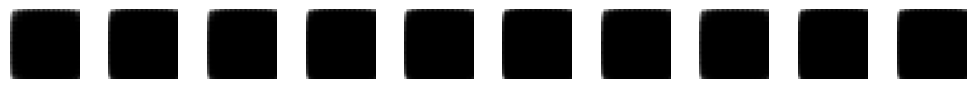

Epoch 1/5, Batch 5, Discriminator Loss: -198.94369506835938, Generator Loss: 242.45721435546875
Epoch 1/5, Batch 6, Discriminator Loss: -348.6724853515625, Generator Loss: 504.9411315917969
Epoch 1/5, Batch 7, Discriminator Loss: -533.4832763671875, Generator Loss: 889.537841796875
Epoch 1/5, Batch 8, Discriminator Loss: -767.46044921875, Generator Loss: 1413.70654296875
Epoch 1/5, Batch 9, Discriminator Loss: -1081.5712890625, Generator Loss: 2103.2392578125


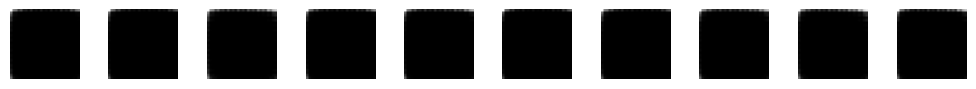

Epoch 1/5, Batch 10, Discriminator Loss: -1421.3271484375, Generator Loss: 2947.38037109375
Epoch 1/5, Batch 11, Discriminator Loss: -1772.33642578125, Generator Loss: 3930.89404296875
Epoch 1/5, Batch 12, Discriminator Loss: -2205.661865234375, Generator Loss: 4765.82177734375
Epoch 1/5, Batch 13, Discriminator Loss: -860.50244140625, Generator Loss: 3173.47705078125
Epoch 1/5, Batch 14, Discriminator Loss: 2207.5107421875, Generator Loss: -776.853271484375


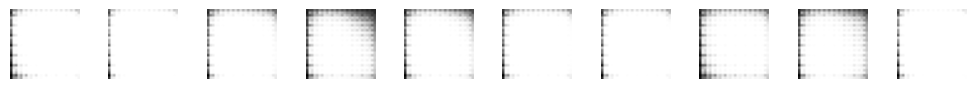

Epoch 1/5, Batch 15, Discriminator Loss: 1719.591064453125, Generator Loss: -1067.9779052734375
Epoch 1/5, Batch 16, Discriminator Loss: 962.58642578125, Generator Loss: -851.5932006835938
Epoch 1/5, Batch 17, Discriminator Loss: 256.5577087402344, Generator Loss: -593.176513671875
Epoch 1/5, Batch 18, Discriminator Loss: -503.50323486328125, Generator Loss: -384.36395263671875
Epoch 1/5, Batch 19, Discriminator Loss: -1230.34228515625, Generator Loss: -266.02471923828125


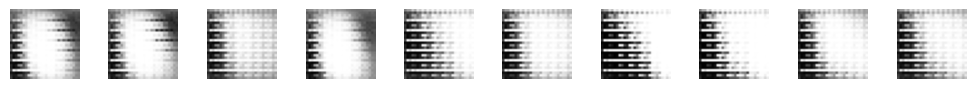

Epoch 1/5, Batch 20, Discriminator Loss: -1749.284912109375, Generator Loss: -418.48468017578125
Epoch 1/5, Batch 21, Discriminator Loss: -2144.770263671875, Generator Loss: -819.7742309570312
Epoch 1/5, Batch 22, Discriminator Loss: -1865.939208984375, Generator Loss: -1763.534912109375
Epoch 1/5, Batch 23, Discriminator Loss: -1578.39990234375, Generator Loss: -2607.8486328125
Epoch 1/5, Batch 24, Discriminator Loss: -1550.309326171875, Generator Loss: -3074.511962890625


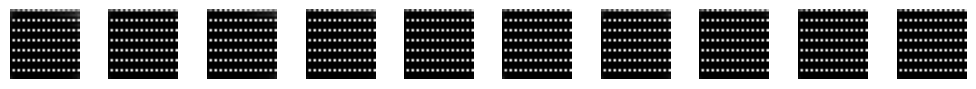

Epoch 1/5, Batch 25, Discriminator Loss: -1796.47119140625, Generator Loss: -3254.072265625
Epoch 1/5, Batch 26, Discriminator Loss: -2042.049072265625, Generator Loss: -3538.026123046875
Epoch 1/5, Batch 27, Discriminator Loss: -2074.4814453125, Generator Loss: -3987.53759765625
Epoch 1/5, Batch 28, Discriminator Loss: -2049.9150390625, Generator Loss: -4334.1083984375
Epoch 1/5, Batch 29, Discriminator Loss: -1477.142578125, Generator Loss: -4829.19140625


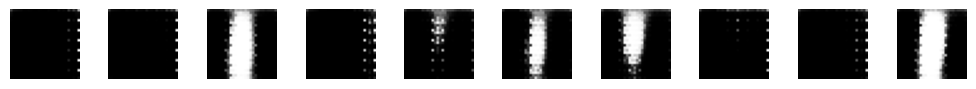

Epoch 1/5, Batch 30, Discriminator Loss: -1510.080078125, Generator Loss: -4737.5771484375
Epoch 1/5, Batch 31, Discriminator Loss: -981.345703125, Generator Loss: -5083.9072265625
Epoch 1/5, Batch 32, Discriminator Loss: -1464.6982421875, Generator Loss: -4363.544921875
Epoch 1/5, Batch 33, Discriminator Loss: -1532.30322265625, Generator Loss: -5798.70849609375
Epoch 1/5, Batch 34, Discriminator Loss: -1184.24609375, Generator Loss: -6247.611328125


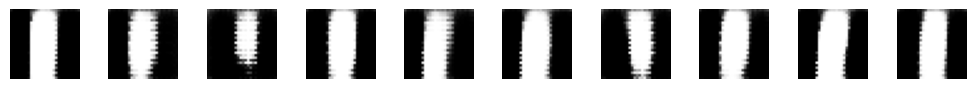

Epoch 1/5, Batch 35, Discriminator Loss: -883.3984375, Generator Loss: -8256.873046875
Epoch 1/5, Batch 36, Discriminator Loss: -597.515625, Generator Loss: -8426.875
Epoch 1/5, Batch 37, Discriminator Loss: -406.9638671875, Generator Loss: -9597.7119140625
Epoch 1/5, Batch 38, Discriminator Loss: -326.9375, Generator Loss: -9887.708984375
Epoch 1/5, Batch 39, Discriminator Loss: -595.658203125, Generator Loss: -10309.509765625


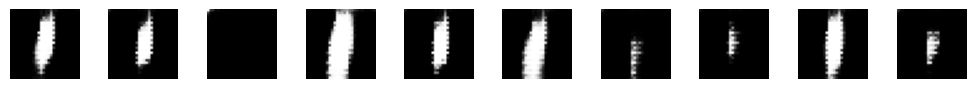

Epoch 1/5, Batch 40, Discriminator Loss: -442.025390625, Generator Loss: -10259.4375
Epoch 1/5, Batch 41, Discriminator Loss: -376.9931640625, Generator Loss: -10364.8544921875
Epoch 1/5, Batch 42, Discriminator Loss: 96.208984375, Generator Loss: -9941.39453125
Epoch 1/5, Batch 43, Discriminator Loss: 78.423828125, Generator Loss: -9695.79296875
Epoch 1/5, Batch 44, Discriminator Loss: -339.611328125, Generator Loss: -7928.541015625


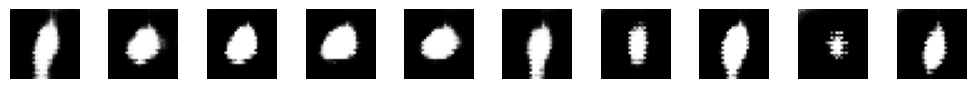

Epoch 1/5, Batch 45, Discriminator Loss: 498.36865234375, Generator Loss: -8011.65380859375
Epoch 1/5, Batch 46, Discriminator Loss: 690.14306640625, Generator Loss: -7320.62451171875
Epoch 1/5, Batch 47, Discriminator Loss: 243.28076171875, Generator Loss: -7359.91650390625
Epoch 1/5, Batch 48, Discriminator Loss: 305.087890625, Generator Loss: -6165.1435546875
Epoch 1/5, Batch 49, Discriminator Loss: 396.47998046875, Generator Loss: -5770.103515625


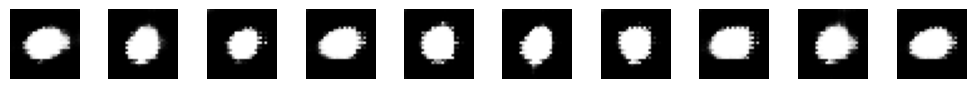

Epoch 1/5, Batch 50, Discriminator Loss: 122.73681640625, Generator Loss: -5433.970703125
Epoch 1/5, Batch 51, Discriminator Loss: -19.0224609375, Generator Loss: -4913.509765625
Epoch 1/5, Batch 52, Discriminator Loss: -139.6083984375, Generator Loss: -4339.318359375
Epoch 1/5, Batch 53, Discriminator Loss: -199.38916015625, Generator Loss: -3557.103515625
Epoch 1/5, Batch 54, Discriminator Loss: -410.53369140625, Generator Loss: -2563.35498046875


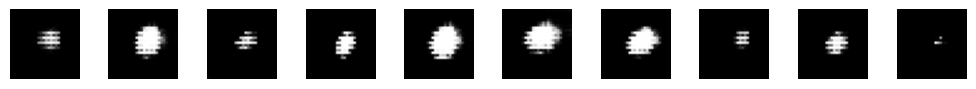

Epoch 1/5, Batch 55, Discriminator Loss: -651.179931640625, Generator Loss: -1529.671875
Epoch 1/5, Batch 56, Discriminator Loss: -654.0882568359375, Generator Loss: -1055.1866455078125
Epoch 1/5, Batch 57, Discriminator Loss: -182.79541015625, Generator Loss: -1848.082763671875
Epoch 1/5, Batch 58, Discriminator Loss: -674.68212890625, Generator Loss: -2573.976318359375
Epoch 1/5, Batch 59, Discriminator Loss: -663.091552734375, Generator Loss: -2797.6240234375


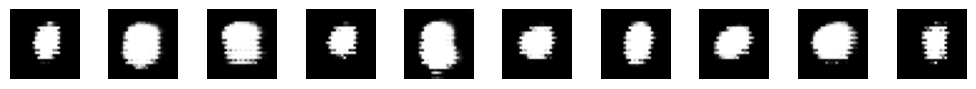

Epoch 1/5, Batch 60, Discriminator Loss: -862.39892578125, Generator Loss: -2893.30419921875
Epoch 1/5, Batch 61, Discriminator Loss: -951.619384765625, Generator Loss: -2977.23486328125
Epoch 1/5, Batch 62, Discriminator Loss: -421.00390625, Generator Loss: -2814.7373046875
Epoch 1/5, Batch 63, Discriminator Loss: -294.065673828125, Generator Loss: -2021.057373046875
Epoch 1/5, Batch 64, Discriminator Loss: -618.9041748046875, Generator Loss: -657.8846435546875


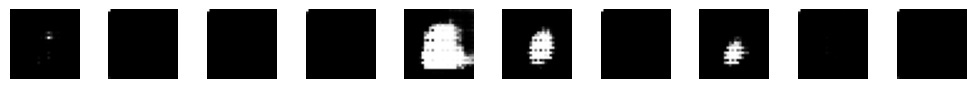

Epoch 1/5, Batch 65, Discriminator Loss: -920.41259765625, Generator Loss: 690.615478515625
Epoch 1/5, Batch 66, Discriminator Loss: -900.6715698242188, Generator Loss: 1465.1644287109375
Epoch 1/5, Batch 67, Discriminator Loss: -373.9571533203125, Generator Loss: 729.40185546875
Epoch 1/5, Batch 68, Discriminator Loss: 438.427734375, Generator Loss: -1522.0126953125
Epoch 1/5, Batch 69, Discriminator Loss: 24.6220703125, Generator Loss: -2578.62744140625


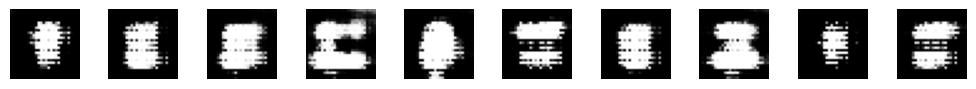

Epoch 1/5, Batch 70, Discriminator Loss: -348.048095703125, Generator Loss: -3324.044677734375
Epoch 1/5, Batch 71, Discriminator Loss: -536.932861328125, Generator Loss: -4079.792236328125
Epoch 1/5, Batch 72, Discriminator Loss: 65.8603515625, Generator Loss: -4917.306640625
Epoch 1/5, Batch 73, Discriminator Loss: 466.0263671875, Generator Loss: -4599.8818359375
Epoch 1/5, Batch 74, Discriminator Loss: 240.182373046875, Generator Loss: -3712.604736328125


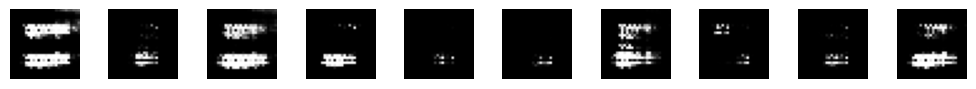

Epoch 1/5, Batch 75, Discriminator Loss: 279.64990234375, Generator Loss: -3364.07275390625
Epoch 1/5, Batch 76, Discriminator Loss: 356.69873046875, Generator Loss: -3730.23388671875
Epoch 1/5, Batch 77, Discriminator Loss: 256.159423828125, Generator Loss: -3529.689208984375
Epoch 1/5, Batch 78, Discriminator Loss: 48.6083984375, Generator Loss: -3711.66259765625
Epoch 1/5, Batch 79, Discriminator Loss: -23.615234375, Generator Loss: -3281.9658203125


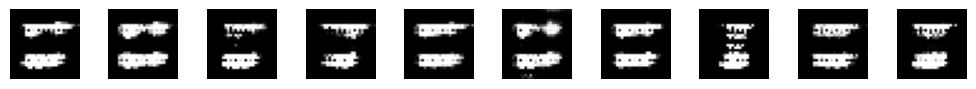

Epoch 1/5, Batch 80, Discriminator Loss: -123.948974609375, Generator Loss: -3440.06982421875
Epoch 1/5, Batch 81, Discriminator Loss: -216.890869140625, Generator Loss: -3117.60498046875
Epoch 1/5, Batch 82, Discriminator Loss: -332.58251953125, Generator Loss: -3292.185546875
Epoch 1/5, Batch 83, Discriminator Loss: -420.9755859375, Generator Loss: -3430.819580078125
Epoch 1/5, Batch 84, Discriminator Loss: -441.242919921875, Generator Loss: -3473.98095703125


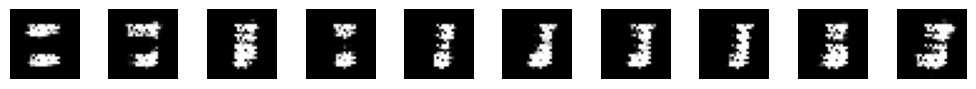

Epoch 1/5, Batch 85, Discriminator Loss: -466.372802734375, Generator Loss: -3371.553466796875
Epoch 1/5, Batch 86, Discriminator Loss: -470.22802734375, Generator Loss: -3193.52294921875
Epoch 1/5, Batch 87, Discriminator Loss: -437.8330078125, Generator Loss: -2967.08935546875
Epoch 1/5, Batch 88, Discriminator Loss: -354.894287109375, Generator Loss: -2863.175048828125
Epoch 1/5, Batch 89, Discriminator Loss: -347.8876953125, Generator Loss: -1531.140625


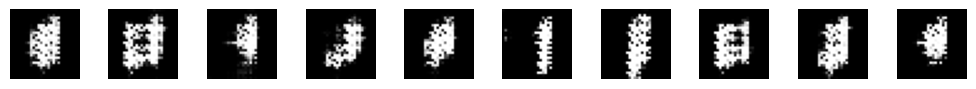

Epoch 1/5, Batch 90, Discriminator Loss: -387.34326171875, Generator Loss: -2668.45068359375
Epoch 1/5, Batch 91, Discriminator Loss: -139.75634765625, Generator Loss: -2234.31298828125
Epoch 1/5, Batch 92, Discriminator Loss: -45.7890625, Generator Loss: -1951.64599609375
Epoch 1/5, Batch 93, Discriminator Loss: -57.283203125, Generator Loss: -2595.4580078125
Epoch 1/5, Batch 94, Discriminator Loss: -224.1016845703125, Generator Loss: -1554.7337646484375


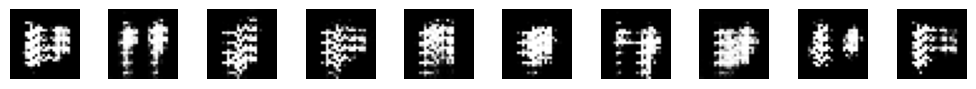

Epoch 1/5, Batch 95, Discriminator Loss: -188.093017578125, Generator Loss: -2581.72607421875
Epoch 1/5, Batch 96, Discriminator Loss: -77.71923828125, Generator Loss: -2435.170654296875
Epoch 1/5, Batch 97, Discriminator Loss: -144.0361328125, Generator Loss: -2428.412109375
Epoch 1/5, Batch 98, Discriminator Loss: -226.6181640625, Generator Loss: -2313.034912109375
Epoch 1/5, Batch 99, Discriminator Loss: -284.49462890625, Generator Loss: -2839.93798828125


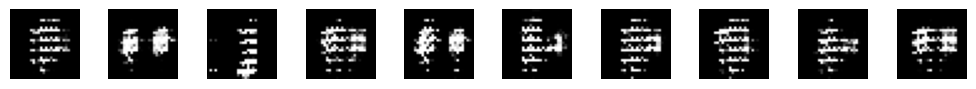

Epoch 1/5, Batch 100, Discriminator Loss: -377.1376953125, Generator Loss: -2142.363037109375
Epoch 1/5, Batch 101, Discriminator Loss: -310.447509765625, Generator Loss: -3228.0146484375
Epoch 1/5, Batch 102, Discriminator Loss: -146.698974609375, Generator Loss: -3071.36474609375
Epoch 1/5, Batch 103, Discriminator Loss: -143.0703125, Generator Loss: -3462.817626953125
Epoch 1/5, Batch 104, Discriminator Loss: -221.672119140625, Generator Loss: -2562.540771484375


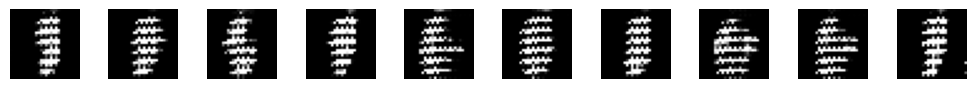

Epoch 1/5, Batch 105, Discriminator Loss: -285.76806640625, Generator Loss: -2875.690673828125
Epoch 1/5, Batch 106, Discriminator Loss: -292.2322998046875, Generator Loss: -2006.4129638671875
Epoch 1/5, Batch 107, Discriminator Loss: -399.6949462890625, Generator Loss: -1994.5667724609375
Epoch 1/5, Batch 108, Discriminator Loss: -355.3231201171875, Generator Loss: -1373.878173828125
Epoch 1/5, Batch 109, Discriminator Loss: -385.91357421875, Generator Loss: -1741.607177734375


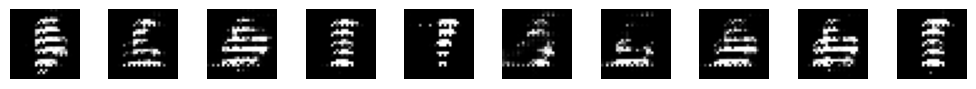

Epoch 1/5, Batch 110, Discriminator Loss: -405.9229736328125, Generator Loss: -933.9560546875
Epoch 1/5, Batch 111, Discriminator Loss: -309.67822265625, Generator Loss: -2283.923828125
Epoch 1/5, Batch 112, Discriminator Loss: -145.886474609375, Generator Loss: -2281.497802734375
Epoch 1/5, Batch 113, Discriminator Loss: -45.37841796875, Generator Loss: -3226.9140625
Epoch 1/5, Batch 114, Discriminator Loss: 34.9111328125, Generator Loss: -2999.84375


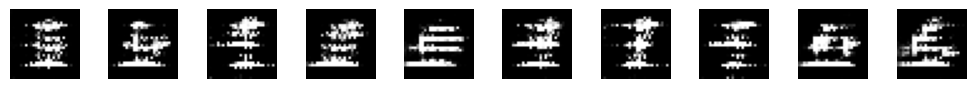

Epoch 1/5, Batch 115, Discriminator Loss: 21.765625, Generator Loss: -4061.7685546875
Epoch 1/5, Batch 116, Discriminator Loss: -27.059814453125, Generator Loss: -3172.2802734375
Epoch 1/5, Batch 117, Discriminator Loss: 5.19140625, Generator Loss: -4279.42236328125
Epoch 1/5, Batch 118, Discriminator Loss: 37.895263671875, Generator Loss: -3485.376953125
Epoch 1/5, Batch 119, Discriminator Loss: 51.3232421875, Generator Loss: -4161.72021484375


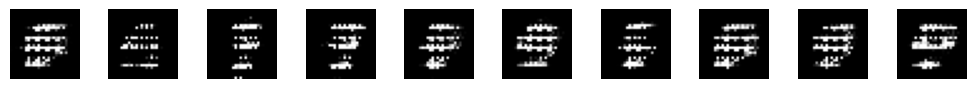

Epoch 1/5, Batch 120, Discriminator Loss: -3.114990234375, Generator Loss: -3491.035888671875
Epoch 1/5, Batch 121, Discriminator Loss: 1.718994140625, Generator Loss: -4076.482666015625
Epoch 1/5, Batch 122, Discriminator Loss: -76.8564453125, Generator Loss: -3325.5166015625
Epoch 1/5, Batch 123, Discriminator Loss: -109.767822265625, Generator Loss: -3760.835693359375
Epoch 1/5, Batch 124, Discriminator Loss: -135.574951171875, Generator Loss: -3332.300537109375


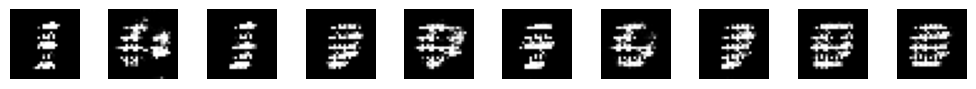

Epoch 1/5, Batch 125, Discriminator Loss: -168.074951171875, Generator Loss: -3438.383056640625
Epoch 1/5, Batch 126, Discriminator Loss: -238.21044921875, Generator Loss: -2325.70849609375
Epoch 1/5, Batch 127, Discriminator Loss: -237.498046875, Generator Loss: -2898.22119140625
Epoch 1/5, Batch 128, Discriminator Loss: -240.99365234375, Generator Loss: -1899.865234375
Epoch 1/5, Batch 129, Discriminator Loss: -205.51513671875, Generator Loss: -2132.869384765625


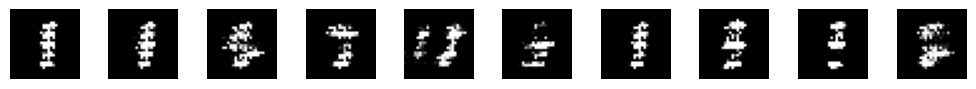

Epoch 1/5, Batch 130, Discriminator Loss: -161.2109375, Generator Loss: -1652.1943359375
Epoch 1/5, Batch 131, Discriminator Loss: -166.6199951171875, Generator Loss: -1901.8814697265625
Epoch 1/5, Batch 132, Discriminator Loss: -157.6597900390625, Generator Loss: -1249.1839599609375
Epoch 1/5, Batch 133, Discriminator Loss: -185.696044921875, Generator Loss: -2433.495361328125
Epoch 1/5, Batch 134, Discriminator Loss: -15.89697265625, Generator Loss: -1982.5535888671875


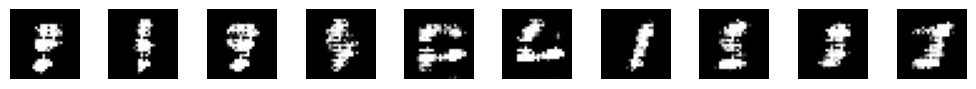

Epoch 1/5, Batch 135, Discriminator Loss: -5.99462890625, Generator Loss: -1931.97314453125
Epoch 1/5, Batch 136, Discriminator Loss: -8.754150390625, Generator Loss: -2310.048828125
Epoch 1/5, Batch 137, Discriminator Loss: -27.4283447265625, Generator Loss: -1739.5743408203125
Epoch 1/5, Batch 138, Discriminator Loss: -109.075439453125, Generator Loss: -2692.736083984375
Epoch 1/5, Batch 139, Discriminator Loss: -98.226318359375, Generator Loss: -1741.94873046875


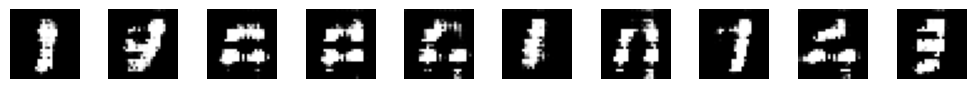

Epoch 1/5, Batch 140, Discriminator Loss: -96.053466796875, Generator Loss: -2638.332275390625
Epoch 1/5, Batch 141, Discriminator Loss: -35.357666015625, Generator Loss: -2030.395263671875
Epoch 1/5, Batch 142, Discriminator Loss: -59.19677734375, Generator Loss: -1932.8355712890625
Epoch 1/5, Batch 143, Discriminator Loss: -96.654296875, Generator Loss: -2029.52001953125
Epoch 1/5, Batch 144, Discriminator Loss: -106.3099365234375, Generator Loss: -1385.6934814453125


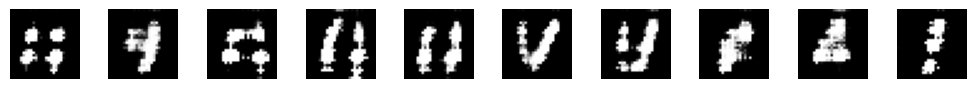

Epoch 1/5, Batch 145, Discriminator Loss: -154.93701171875, Generator Loss: -2139.54638671875
Epoch 1/5, Batch 146, Discriminator Loss: -183.383544921875, Generator Loss: -830.8276977539062
Epoch 1/5, Batch 147, Discriminator Loss: -127.6343994140625, Generator Loss: -2007.5799560546875
Epoch 1/5, Batch 148, Discriminator Loss: -79.942138671875, Generator Loss: -1446.359619140625
Epoch 1/5, Batch 149, Discriminator Loss: -100.659423828125, Generator Loss: -2286.748046875


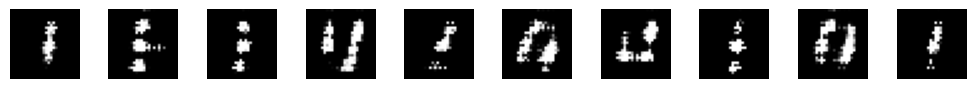

Epoch 1/5, Batch 150, Discriminator Loss: -143.0093994140625, Generator Loss: -1111.7786865234375
Epoch 1/5, Batch 151, Discriminator Loss: -108.205078125, Generator Loss: -2105.91552734375
Epoch 1/5, Batch 152, Discriminator Loss: -81.795654296875, Generator Loss: -1382.0751953125
Epoch 1/5, Batch 153, Discriminator Loss: -116.894287109375, Generator Loss: -1900.12353515625
Epoch 1/5, Batch 154, Discriminator Loss: -112.958740234375, Generator Loss: -960.755615234375


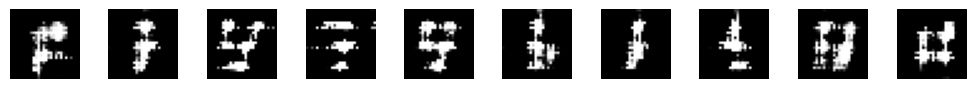

Epoch 1/5, Batch 155, Discriminator Loss: -142.97314453125, Generator Loss: -1634.632080078125
Epoch 1/5, Batch 156, Discriminator Loss: -118.51837158203125, Generator Loss: -531.8997802734375
Epoch 1/5, Batch 157, Discriminator Loss: -137.7525634765625, Generator Loss: -1338.668212890625
Epoch 1/5, Batch 158, Discriminator Loss: -101.20123291015625, Generator Loss: -463.56793212890625
Epoch 1/5, Batch 159, Discriminator Loss: -93.4912109375, Generator Loss: -1396.776611328125


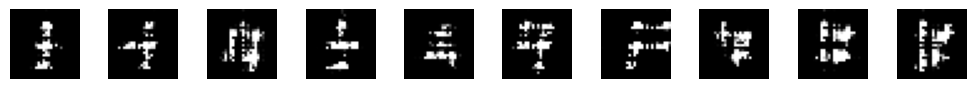

Epoch 1/5, Batch 160, Discriminator Loss: -130.05078125, Generator Loss: -245.37911987304688
Epoch 1/5, Batch 161, Discriminator Loss: -78.499267578125, Generator Loss: -1324.52294921875
Epoch 1/5, Batch 162, Discriminator Loss: -52.408935546875, Generator Loss: -1421.936767578125
Epoch 1/5, Batch 163, Discriminator Loss: -73.507080078125, Generator Loss: -1233.672607421875
Epoch 1/5, Batch 164, Discriminator Loss: -143.396728515625, Generator Loss: -2267.794921875


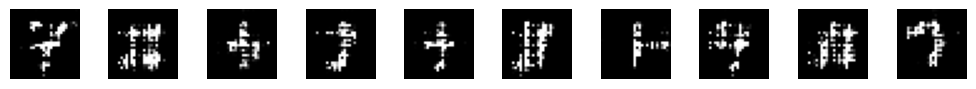

Epoch 1/5, Batch 165, Discriminator Loss: -138.119140625, Generator Loss: -1373.7335205078125
Epoch 1/5, Batch 166, Discriminator Loss: -125.792236328125, Generator Loss: -2257.996337890625
Epoch 1/5, Batch 167, Discriminator Loss: -60.912353515625, Generator Loss: -1929.84033203125
Epoch 1/5, Batch 168, Discriminator Loss: -83.13916015625, Generator Loss: -2732.4169921875
Epoch 1/5, Batch 169, Discriminator Loss: -178.6326904296875, Generator Loss: -1601.4078369140625


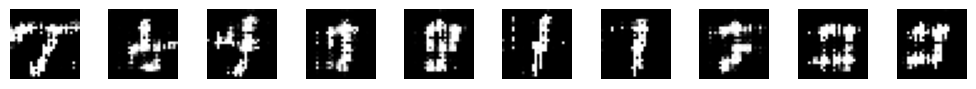

Epoch 1/5, Batch 170, Discriminator Loss: -97.485595703125, Generator Loss: -2786.68017578125
Epoch 1/5, Batch 171, Discriminator Loss: -31.70751953125, Generator Loss: -2702.131591796875
Epoch 1/5, Batch 172, Discriminator Loss: -94.4317626953125, Generator Loss: -1985.9295654296875
Epoch 1/5, Batch 173, Discriminator Loss: -88.19482421875, Generator Loss: -2856.330078125
Epoch 1/5, Batch 174, Discriminator Loss: -33.966796875, Generator Loss: -2540.871826171875


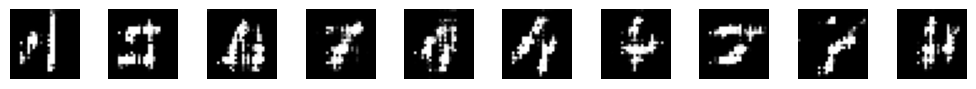

Epoch 1/5, Batch 175, Discriminator Loss: -46.962890625, Generator Loss: -2150.515625
Epoch 1/5, Batch 176, Discriminator Loss: -67.7587890625, Generator Loss: -2962.45361328125
Epoch 1/5, Batch 177, Discriminator Loss: -63.714111328125, Generator Loss: -2012.22412109375
Epoch 1/5, Batch 178, Discriminator Loss: -32.791259765625, Generator Loss: -2690.51953125
Epoch 1/5, Batch 179, Discriminator Loss: -30.7099609375, Generator Loss: -2225.63720703125


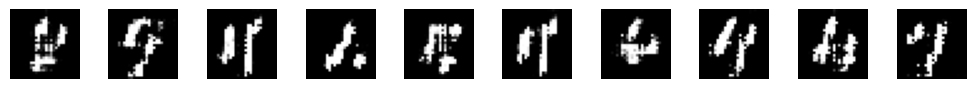

Epoch 1/5, Batch 180, Discriminator Loss: -58.7236328125, Generator Loss: -2800.95458984375
Epoch 1/5, Batch 181, Discriminator Loss: -99.4237060546875, Generator Loss: -1719.3280029296875
Epoch 1/5, Batch 182, Discriminator Loss: -82.594970703125, Generator Loss: -2667.76611328125
Epoch 1/5, Batch 183, Discriminator Loss: -18.92578125, Generator Loss: -2195.232421875
Epoch 1/5, Batch 184, Discriminator Loss: -18.6123046875, Generator Loss: -2572.40869140625


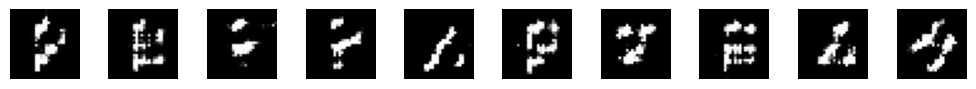

Epoch 1/5, Batch 185, Discriminator Loss: -86.9871826171875, Generator Loss: -1524.5599365234375
Epoch 1/5, Batch 186, Discriminator Loss: -111.858642578125, Generator Loss: -2496.551025390625
Epoch 1/5, Batch 187, Discriminator Loss: -28.2525634765625, Generator Loss: -1966.0704345703125
Epoch 1/5, Batch 188, Discriminator Loss: -49.989501953125, Generator Loss: -1431.410888671875
Epoch 1/5, Batch 189, Discriminator Loss: -81.93212890625, Generator Loss: -2261.2978515625


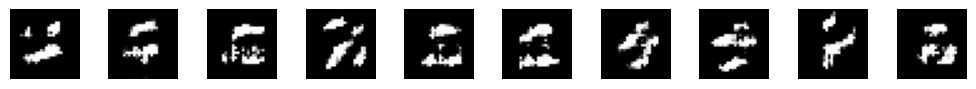

Epoch 1/5, Batch 190, Discriminator Loss: -21.130126953125, Generator Loss: -1916.79541015625
Epoch 1/5, Batch 191, Discriminator Loss: -35.8009033203125, Generator Loss: -1351.2008056640625
Epoch 1/5, Batch 192, Discriminator Loss: -60.375732421875, Generator Loss: -1947.34130859375
Epoch 1/5, Batch 193, Discriminator Loss: -34.6463623046875, Generator Loss: -1692.1898193359375
Epoch 1/5, Batch 194, Discriminator Loss: -27.8197021484375, Generator Loss: -1446.676025390625


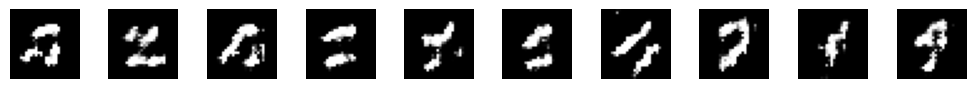

Epoch 1/5, Batch 195, Discriminator Loss: -54.82916259765625, Generator Loss: -936.1485595703125
Epoch 1/5, Batch 196, Discriminator Loss: -111.33544921875, Generator Loss: -1768.059814453125
Epoch 1/5, Batch 197, Discriminator Loss: -49.18463134765625, Generator Loss: -961.9852294921875
Epoch 1/5, Batch 198, Discriminator Loss: -59.2938232421875, Generator Loss: -1582.5335693359375
Epoch 1/5, Batch 199, Discriminator Loss: -47.01708984375, Generator Loss: -1076.8668212890625


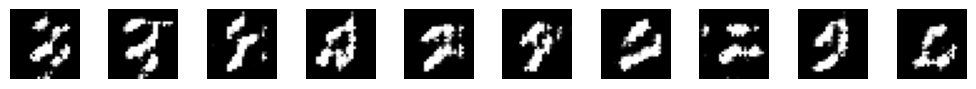

Epoch 1/5, Batch 200, Discriminator Loss: -98.462890625, Generator Loss: -1960.1318359375
Epoch 1/5, Batch 201, Discriminator Loss: -91.44683837890625, Generator Loss: -923.6865844726562
Epoch 1/5, Batch 202, Discriminator Loss: -66.71142578125, Generator Loss: -1620.716064453125
Epoch 1/5, Batch 203, Discriminator Loss: -46.6737060546875, Generator Loss: -1324.81494140625
Epoch 1/5, Batch 204, Discriminator Loss: -50.9228515625, Generator Loss: -1608.90185546875


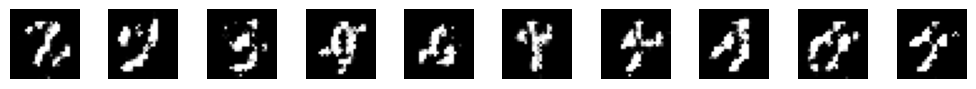

Epoch 1/5, Batch 205, Discriminator Loss: -45.6553955078125, Generator Loss: -1805.4852294921875
Epoch 1/5, Batch 206, Discriminator Loss: -73.882568359375, Generator Loss: -1030.8370361328125
Epoch 1/5, Batch 207, Discriminator Loss: -192.0341796875, Generator Loss: -2126.7841796875
Epoch 1/5, Batch 208, Discriminator Loss: -37.4755859375, Generator Loss: -2021.7001953125
Epoch 1/5, Batch 209, Discriminator Loss: -123.032470703125, Generator Loss: -1176.245849609375


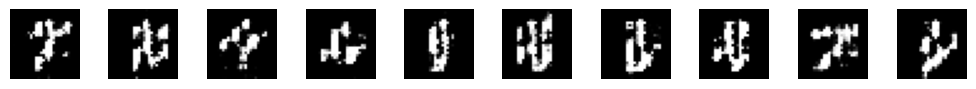

Epoch 1/5, Batch 210, Discriminator Loss: -71.8887939453125, Generator Loss: -1920.7984619140625
Epoch 1/5, Batch 211, Discriminator Loss: -92.568115234375, Generator Loss: -2093.476318359375
Epoch 1/5, Batch 212, Discriminator Loss: -123.27783203125, Generator Loss: -1348.9326171875
Epoch 1/5, Batch 213, Discriminator Loss: -103.2618408203125, Generator Loss: -2031.3074951171875
Epoch 1/5, Batch 214, Discriminator Loss: -76.8736572265625, Generator Loss: -1954.5487060546875


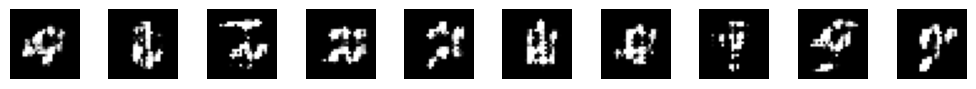

Epoch 1/5, Batch 215, Discriminator Loss: -59.118408203125, Generator Loss: -1766.44970703125
Epoch 1/5, Batch 216, Discriminator Loss: -72.9691162109375, Generator Loss: -1167.266357421875
Epoch 1/5, Batch 217, Discriminator Loss: -125.062744140625, Generator Loss: -2064.770263671875
Epoch 1/5, Batch 218, Discriminator Loss: -28.0565185546875, Generator Loss: -1821.0321044921875
Epoch 1/5, Batch 219, Discriminator Loss: -71.86016845703125, Generator Loss: -900.7128295898438


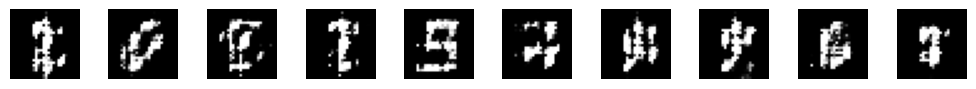

Epoch 1/5, Batch 220, Discriminator Loss: -23.937744140625, Generator Loss: -1623.4315185546875
Epoch 1/5, Batch 221, Discriminator Loss: -15.6920166015625, Generator Loss: -1960.0291748046875
Epoch 1/5, Batch 222, Discriminator Loss: -66.16107177734375, Generator Loss: -992.1593627929688
Epoch 1/5, Batch 223, Discriminator Loss: -9.2955322265625, Generator Loss: -1223.5667724609375
Epoch 1/5, Batch 224, Discriminator Loss: -51.953369140625, Generator Loss: -1429.232177734375


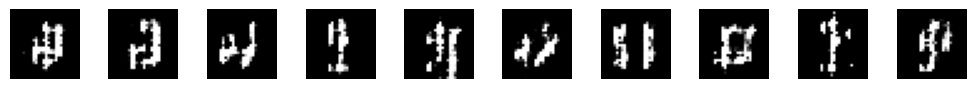

Epoch 1/5, Batch 225, Discriminator Loss: -84.731201171875, Generator Loss: -920.712158203125
Epoch 1/5, Batch 226, Discriminator Loss: -99.93212890625, Generator Loss: -1440.424560546875
Epoch 1/5, Batch 227, Discriminator Loss: -92.2484130859375, Generator Loss: -1350.9527587890625
Epoch 1/5, Batch 228, Discriminator Loss: -75.626953125, Generator Loss: -1142.609375
Epoch 1/5, Batch 229, Discriminator Loss: -81.190185546875, Generator Loss: -1564.23583984375


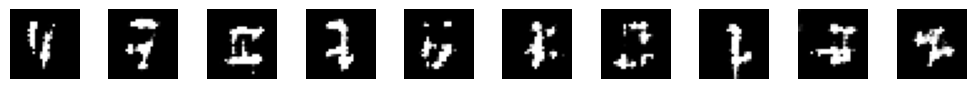

Epoch 1/5, Batch 230, Discriminator Loss: -113.0972900390625, Generator Loss: -539.3173828125
Epoch 1/5, Batch 231, Discriminator Loss: -56.558837890625, Generator Loss: -1184.650146484375
Epoch 1/5, Batch 232, Discriminator Loss: -50.884033203125, Generator Loss: -1670.732666015625
Epoch 1/5, Batch 233, Discriminator Loss: -74.75201416015625, Generator Loss: -731.265625
Epoch 1/5, Batch 234, Discriminator Loss: -10.5018310546875, Generator Loss: -1273.86181640625


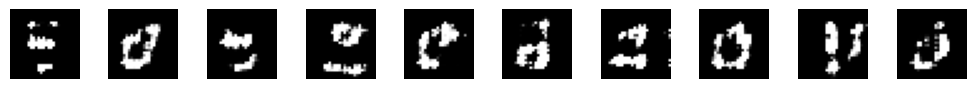

End of epoch 1, Discriminator Loss: -10.5018310546875, Generator Loss: -1273.86181640625
Epoch 2/5, Batch 0, Discriminator Loss: -11.1522216796875, Generator Loss: -1569.3316650390625
Epoch 2/5, Batch 1, Discriminator Loss: -120.5428466796875, Generator Loss: -508.871826171875
Epoch 2/5, Batch 2, Discriminator Loss: -45.1343994140625, Generator Loss: -1342.1309814453125
Epoch 2/5, Batch 3, Discriminator Loss: -89.82080078125, Generator Loss: -1836.3955078125
Epoch 2/5, Batch 4, Discriminator Loss: -18.1317138671875, Generator Loss: -1172.061767578125


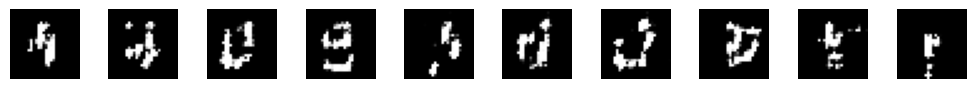

Epoch 2/5, Batch 5, Discriminator Loss: -93.323486328125, Generator Loss: -306.4359130859375
Epoch 2/5, Batch 6, Discriminator Loss: -31.6112060546875, Generator Loss: -1304.6534423828125
Epoch 2/5, Batch 7, Discriminator Loss: -72.2652587890625, Generator Loss: -1878.3388671875
Epoch 2/5, Batch 8, Discriminator Loss: -41.58984375, Generator Loss: -1272.117431640625
Epoch 2/5, Batch 9, Discriminator Loss: -83.1920166015625, Generator Loss: -829.9713134765625


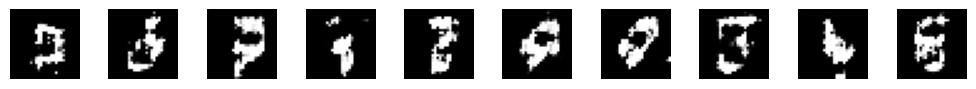

Epoch 2/5, Batch 10, Discriminator Loss: -68.300048828125, Generator Loss: -1489.8238525390625
Epoch 2/5, Batch 11, Discriminator Loss: -53.5594482421875, Generator Loss: -1520.648193359375
Epoch 2/5, Batch 12, Discriminator Loss: -114.99591064453125, Generator Loss: -657.0746459960938
Epoch 2/5, Batch 13, Discriminator Loss: -60.534912109375, Generator Loss: -1219.029052734375
Epoch 2/5, Batch 14, Discriminator Loss: -59.6962890625, Generator Loss: -1294.264404296875


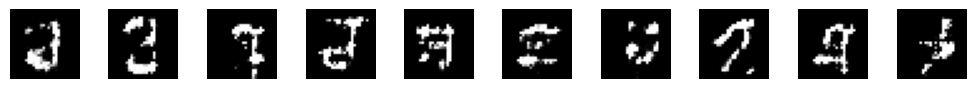

Epoch 2/5, Batch 15, Discriminator Loss: -67.14801025390625, Generator Loss: -918.102783203125
Epoch 2/5, Batch 16, Discriminator Loss: -69.434814453125, Generator Loss: -1536.63037109375
Epoch 2/5, Batch 17, Discriminator Loss: -64.125732421875, Generator Loss: -1328.2010498046875
Epoch 2/5, Batch 18, Discriminator Loss: -87.48114013671875, Generator Loss: -775.3027954101562
Epoch 2/5, Batch 19, Discriminator Loss: -119.8145751953125, Generator Loss: -1841.986328125


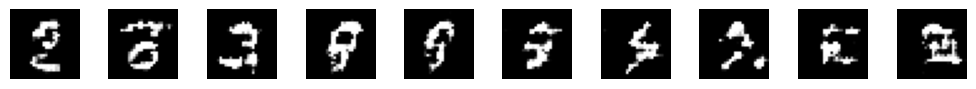

Epoch 2/5, Batch 20, Discriminator Loss: -50.4302978515625, Generator Loss: -1404.2242431640625
Epoch 2/5, Batch 21, Discriminator Loss: -85.7242431640625, Generator Loss: -804.439453125
Epoch 2/5, Batch 22, Discriminator Loss: -101.4315185546875, Generator Loss: -1638.80859375
Epoch 2/5, Batch 23, Discriminator Loss: -52.03564453125, Generator Loss: -1840.4482421875
Epoch 2/5, Batch 24, Discriminator Loss: -98.706298828125, Generator Loss: -1179.7548828125


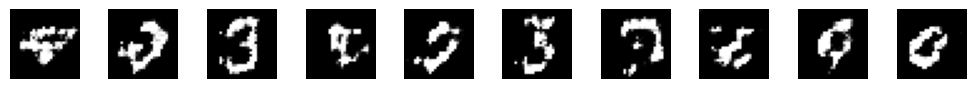

Epoch 2/5, Batch 25, Discriminator Loss: -27.8179931640625, Generator Loss: -1849.406982421875
Epoch 2/5, Batch 26, Discriminator Loss: -49.062744140625, Generator Loss: -2317.66455078125
Epoch 2/5, Batch 27, Discriminator Loss: -90.7652587890625, Generator Loss: -1273.4722900390625
Epoch 2/5, Batch 28, Discriminator Loss: -16.3966064453125, Generator Loss: -1833.44775390625
Epoch 2/5, Batch 29, Discriminator Loss: -34.7484130859375, Generator Loss: -1416.141845703125


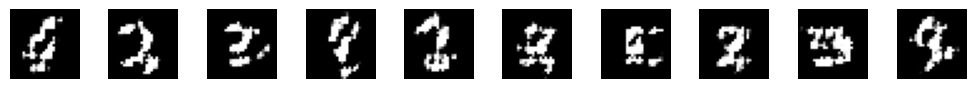

Epoch 2/5, Batch 30, Discriminator Loss: -80.441162109375, Generator Loss: -2239.92138671875
Epoch 2/5, Batch 31, Discriminator Loss: -21.33935546875, Generator Loss: -1817.8648681640625
Epoch 2/5, Batch 32, Discriminator Loss: -17.2440185546875, Generator Loss: -1727.6796875
Epoch 2/5, Batch 33, Discriminator Loss: -33.874755859375, Generator Loss: -1761.0875244140625
Epoch 2/5, Batch 34, Discriminator Loss: -42.4979248046875, Generator Loss: -1839.4078369140625


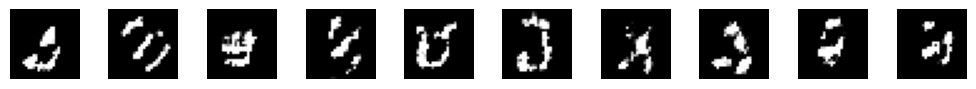

In [ ]:
n_epochs = 5
coding_size = 100
d_iterations = 3

history = {'d_loss': [], 'g_loss': []}

def plot_generated_images(generator, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = tf.random.normal([examples, coding_size])
    generated_images = generator(noise, training=False)
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


for epoch in range(n_epochs):
    n_batches = 0
    for xbatch in dataset:
        for _ in range(d_iterations):
            with tf.GradientTape() as d_tape:
                noise = tf.random.normal([batch_size, coding_size])
                generated_images = generator(noise)
                real_predictions = discriminator(xbatch)
                generated_predictions = discriminator(generated_images)
                d_loss = discriminator_loss(real_predictions, generated_predictions)
            discriminator_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
            d_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


        with tf.GradientTape() as g_tape:
            noise = tf.random.normal([batch_size, coding_size])
            generated_images = generator(noise)
            real_predictions = discriminator(xbatch)
            generated_predictions = discriminator(generated_images)
            d_loss = discriminator_loss(real_predictions, generated_predictions)
            g_loss = generator_loss(generated_predictions)
        generator_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
        g_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))


        # Convert the losses to numpy for better readability
        d_loss_np = tf.reduce_mean(d_loss).numpy()
        g_loss_np = tf.reduce_mean(g_loss).numpy()

        print(f'Epoch {epoch + 1}/{n_epochs}, Batch {n_batches}, Discriminator Loss: {d_loss_np}, Generator Loss: {g_loss_np}')

        n_batches += 1

        if n_batches % 5 == 0:
            plot_generated_images(generator, epoch)

    print(f'End of epoch {epoch + 1}, Discriminator Loss: {d_loss_np}, Generator Loss: {g_loss_np}')



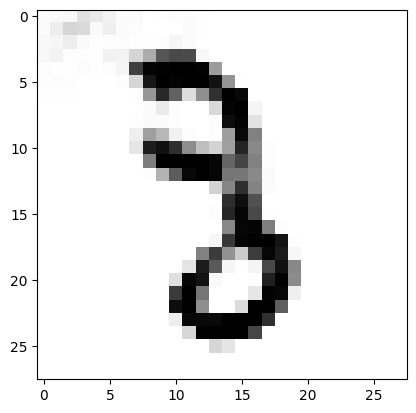

In [ ]:
teste = generator(tf.random.normal([1, 100]))
teste = teste.numpy().reshape(28, 28)
plt.imshow(teste, cmap = 'binary')